rsync -arvt nmhoang@frontera.tacc.utexas.edu:/work/08832/nmhoang/ls6/JAX_GNN_DG/1D_Burgers_equation/Network .
rsync -arvt nvhai@frontera.tacc.utexas.edu:/work/08171/nvhai/ls6/JAX_GNN_DG/1D_wave_eq/Network .

rsync -arvt nvhai@frontera.tacc.utexas.edu:/work/08171/nvhai/ls6/JAX_GNN_DG/1D_wave_eq/data .

rsync data -arvt nmhoang@frontera.tacc.utexas.edu:/work/08832/nmhoang/ls6/JAX_GNN_DG/1D_wave_eq/
rsync -arvt data nvhai@frontera.tacc.utexas.edu:/work/08171/nvhai/ls6/JAX_GNN_DG/1D_wave_eq/

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.tri as tri
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm  # Colour map
import matplotlib.animation as animatio
import matplotlib.font_manager
params = {'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 20, 'xtick.labelsize':14, 'ytick.labelsize':14}
pylab.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'Arial'

import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
jax.config.update("jax_enable_x64", True)
from jax.example_libraries import optimizers
import jax.numpy as jnp
from jax import grad, vmap, jit, lax
import jraph
import haiku as hk
import jax.tree_util as tree
from jraph._src import utils

import pandas as pd
import numpy as np

import pickle
import time



In [2]:


def load_plotfunction(alpha1, alpha2, alpha3, alpha4, type):
    # ## Loading data 
    n_seq = 1
    mc_alpha = int(alpha1)

    num_train = 200
    num_test = 10

    learning_rate = 1e-3
    batch_size = num_train if num_train == 3 else 10
    num_epochs = 1000000

    # In time space
    N = int(np.loadtxt('../MATLAB/N.txt', delimiter = ','))
    K = int(np.loadtxt('../MATLAB/K.txt', delimiter = ','))
    x = np.loadtxt('../MATLAB/x.txt', delimiter = ',')
    LIFT = np.loadtxt('../MATLAB/LIFT.txt', delimiter = ',')
    Dr = np.loadtxt('../MATLAB/Dr.txt', delimiter = ',')
    Fscale = np.loadtxt('../MATLAB/Fscale.txt', delimiter = ',')
    rk4a = np.loadtxt('../MATLAB/rk4a.txt', delimiter = ',')
    rk4b = np.loadtxt('../MATLAB/rk4b.txt', delimiter = ',')
    rx = np.loadtxt('../MATLAB/rx.txt', delimiter = ',')
    vmapM = np.loadtxt('../MATLAB/vmapM.txt', delimiter = ',',dtype = int) - 1
    vmapP = np.loadtxt('../MATLAB/vmapP.txt', delimiter = ',',dtype = int) - 1
    vmapI = np.loadtxt('../MATLAB/vmapI.txt', delimiter = ',',dtype = int) - 1
    vmapO = np.loadtxt('../MATLAB/vmapO.txt', delimiter = ',',dtype = int) - 1
    mapI = np.loadtxt('../MATLAB/mapI.txt', delimiter = ',',dtype = int) - 1
    mapO = np.loadtxt('../MATLAB/mapO.txt', delimiter = ',',dtype = int) - 1
    nx = np.loadtxt('../MATLAB/nx.txt', delimiter = ',')
    Np = N + 1
    Nfp = 1
    Nfaces=2
    a = 1
    alpha=1

    dt = 0.01

    nt_step_train = 41
    nt_step_test = 2005

    noise_level = alpha2

    filename = 'Wave_eq_DG_GNN_NO_EMBED_receiver_flux_dim' + str(int(alpha3)) +'MCalpha_' + str(mc_alpha) + '_noise_' + str(noise_level) + '_lr_' + str(learning_rate) + '_batch_' + str(batch_size) + '_nseq_' + str(n_seq) + '_num_epochs_' + str(num_epochs)

    #! 1. Loading data by pandas
    Test_data = pd.read_csv('../data/Test_d_'  + str(num_test) + '_Nt_' + str(nt_step_test) + '_K_' + str(K) + '_Np_' + str(N) + '.csv') 
    Test_data = np.reshape(Test_data.to_numpy(), (num_test,nt_step_test, K * Np))
    
    Test_data_2 = pd.read_csv('../data/Test_d_'  + str(num_test) + '_Nt_' + str(401) + '_K_' + str(K) + '_Np_' + str(N) + '.csv') 
    Test_data_2 = np.reshape(Test_data_2.to_numpy(), (num_test,401, K * Np))

    print(filename)
    # import pdb; pdb.set_trace()

    #! 2. Building up a neural network
    def build_toy_graph(u) -> jraph.GraphsTuple:
        """Define a four node graph, each node has a scalar as its feature."""

        # Nodes are defined implicitly by their features.
        # We will add four nodes, each with a feature, e.g. each node has feature of N_p values,
        node_features = jnp.reshape(u,(K,Np))

        # We will now specify 5 directed edges connecting the nodes we defined above.
        # We define this with `senders` (source node indices) and `receivers`
        senders = jnp.concatenate((jnp.asarray(range(K)),jnp.asarray(range(K))))
        receivers = jnp.concatenate((jnp.roll(jnp.asarray(range(K)),-1), jnp.roll(jnp.asarray(range(K)),1)))

        temp = receivers
        receivers = senders
        senders = temp
        
        # You can optionally add edge attributes to the 5 edges.
        # WE DO NOT NEED EGED ATTRIBUTES, AT THE MOMENT
        edges = jnp.array([[0.]])
        
        # We then save the number of nodes and the number of edges.
        n_node = jnp.array([K])
        n_edge = jnp.array([2*K])

        # Optionally you can add `global` information, such as a graph label.
        global_context = jnp.array([[1]])  # Same feature dims as nodes and edges.
        graph = jraph.GraphsTuple(
            nodes=node_features,
            edges=edges,
            senders=senders,
            receivers=receivers,
            n_node=n_node,
            n_edge=n_edge,
            globals=global_context
        )
        return graph

    graph_base = build_toy_graph(Test_data[0,0,:])

    def u_2_graph(u):
        """Assign new node attributes to the base graph"""
        A = jnp.reshape(u,(K,Np))
        B = jnp.concatenate((A, x.T), axis = 1)
        return graph_base._replace(nodes=B)

    def GraphMapFeatures(embed_node_fn):
        def Embed(graphs_tuple):
            return graphs_tuple._replace(nodes=embed_node_fn(graphs_tuple.nodes))
        return Embed

    def net_embed(graphs_tuple):
        embedder = GraphMapFeatures(embed_node_fn = hk.Sequential([hk.Linear(int(alpha3)), jax.nn.relu, hk.Linear(int(alpha3))]))
        return embedder(graphs_tuple)

    def GraphNetwork_simplified(update_edge_fn, update_node_fn, aggregate_edges_for_nodes_fn = utils.segment_sum):

        def _ApplyGraphNet(graph):
            
            nodes, _, receivers, senders, _, _, _ = graph

            sum_n_node = tree.tree_leaves(nodes)[0].shape[0]
            
            # Paring two elements of which the egde connects
            edges = update_edge_fn(tree.tree_map(lambda n: n[senders], nodes), tree.tree_map(lambda n: n[receivers], nodes))

            # Updating the nodes from neighbor egdes and the element/node itself
            received_neighbor_attributes = jnp.concatenate((edges[K:], edges[:K]), axis = 1)
            nodes = update_node_fn(nodes, received_neighbor_attributes)
            
            return nodes.flatten() # we can return a graph, but we do not need the graph at the moment

        return _ApplyGraphNet

    @jraph.concatenated_args
    def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
        """Edge update function for graph net."""
        net = hk.Sequential(
            [hk.Linear(int(alpha3)), jax.nn.relu,
            hk.Linear(int(alpha3))])
        return net(feats)

    @jraph.concatenated_args
    def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
        """Node update function for graph net."""
        net = hk.Sequential(
            [hk.Linear(int(alpha3)), jax.nn.relu,
            hk.Linear(int(Np))])
        return net(feats)

    def net_update(graphs_tuple):
        net = GraphNetwork_simplified(update_node_fn=node_update_fn, update_edge_fn=edge_update_fn)
        return net(graphs_tuple)

    def net_fn(u):
        return net_update((u_2_graph(u)))

    net = hk.without_apply_rng(hk.transform(net_fn))
    init_params = net.init(jax.random.PRNGKey(1), Test_data[0,0,:])

    #! 3. Numerical solver + neural network solver (single time step)
    #! STEP 3.1:: Define numerical forward solver (Back-Euler scheme)

    def AdvecRHS1D(u):
        u_transpose = u.T.flatten()
        nx_transpose = nx.T.flatten()
        # form field differences at faces
        alpha = 1
        du_transpose = (u_transpose[vmapM] - u_transpose[vmapP]) * (nx_transpose - (1-alpha)*np.abs(nx_transpose))/2

        # Impose periodic conditions
        # impose boundary condition at x=0
        uin = u_transpose[-1]
        du_transpose = du_transpose.at[mapI].set((u_transpose[vmapI] - uin) * (nx_transpose[mapI] - (1-alpha)*np.abs(nx_transpose[mapI]))/2)
        
        # impose boundary condition at x=1
        uout = u_transpose[0]
        du_transpose = du_transpose.at[mapO].set((uout - u_transpose[vmapO]) * (nx_transpose[mapI] - (1-alpha)*np.abs(nx_transpose[mapI]))/2)
        
        # compute right hand sides of the semi-discrete PDE
        du = jnp.reshape(du_transpose, (K, Nfp*Nfaces)).T
        rhsu = -rx*(Dr@u) + LIFT@(Fscale*(du))
        return rhsu

    def single_solve_forward(u_ti):
        u = jnp.reshape(u_ti, (K, Np)).T
        resu = jnp.zeros((Np, K))
        for INTRK in range(0,5):
            rhsu = AdvecRHS1D(u)
            resu = rk4a[INTRK]*resu + dt*rhsu
            u = u + rk4b[INTRK]*resu
        return u.T.flatten()

    #! STEP 3.2:: Define neural network forward solver (Back-Euler scheme)
    def single_forward_pass(params, u_ti):
        # u = single_solve_forward(u_ti) # This is for debugging the training architecture
        u = u_ti - dt * net.apply(params, u_ti)
        return u

    #! 4. Training loss functions
    def MSE(pred, true):
        return jnp.mean(jnp.square(pred - true))

    def squential_S_phase(i, args):
        
        loss_ml, loss_mc, u_tilde, u_true, params = args
        
        # The numerical solver solutions u_tilde branch
        u_bar = single_solve_forward(u_tilde)
        
        # The neural network solver solutions u_tilde branch
        u_tilde = single_forward_pass(params, u_tilde)
        
        # The machine learning loss
        loss_ml += MSE(u_tilde, u_true[i+1])
        
        # The model-constrained loss
        loss_mc += MSE(u_tilde, u_bar)

        return loss_ml, loss_mc, u_tilde, u_true, params

    def loss_one_sample_one_time(params, u):
        loss_ml = 0
        loss_mc = 0
        u0_tilde = u[0, :]
        
        # for the following steps up to sequential steps n_seq
        loss_ml,loss_mc, _, _, _ = lax.fori_loop(0, n_seq+1, squential_S_phase, (loss_ml, loss_mc, u0_tilde, u, params))
        
        return loss_ml + mc_alpha * loss_mc

    loss_one_sample_one_time_batch = jit(vmap(loss_one_sample_one_time, in_axes = (None, 0), out_axes=0))

    def transform_one_sample_data(u_one_sample):
        u_out = jnp.zeros((nt_step_train - n_seq - 1, n_seq+2, K * Np))
        for i in range(nt_step_train-n_seq-1):
            u_out = u_out.at[i,:,:].set(u_one_sample[i:i + n_seq + 2,:])
        return u_out

    def loss_one_sample(params,u_one_sample):
        u_batch_nt = transform_one_sample_data(u_one_sample)
        return jnp.sum(loss_one_sample_one_time_batch(params, u_batch_nt))

    loss_one_sample_batch = jit(vmap(loss_one_sample, in_axes = (None, 0), out_axes=0))

    def LossmcDNN(params, data):
        return jnp.sum(loss_one_sample_batch(params, data))

    # ## Computing test error, predictions over all time steps
    def neural_solver(params, U_test):
        
        u = U_test[0,:]
        U = jnp.zeros((nt_step_test, K * Np))
        U = U.at[0, :].set(u)
        
        for i in range(1, nt_step_test):
            u = single_forward_pass(params, u)
            U = U.at[i, :].set(u)
            
        return U

    neural_solver_batch = vmap(neural_solver, in_axes = (None, 0))


    # @jit
    def test_acc(params, Test_set):
        return MSE(neural_solver_batch(params, Test_set), Test_set)

    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = int(num_complete_batches) + int(bool(leftover))

    opt_int, opt_update, opt_get_params = optimizers.adam(learning_rate)
    opt_state = opt_int(init_params)
    
    if type == 'best':
        opt_state = optimizers.pack_optimizer_state(pickle.load(open('../Network/Best_' + filename, "rb")))
    
    if type == 'end':
        opt_state = optimizers.pack_optimizer_state(pickle.load(open('../Network/End_' + filename, "rb")))
        
    best_params = opt_get_params(opt_state)
    
    # test_accuracy = test_acc(opt_get_params(opt_state), Test_data)
    # print(test_accuracy)
    pred_sols = neural_solver_batch(best_params, Test_data)
    
    return best_params, neural_solver, Test_data, Test_data_2, K, N, single_forward_pass, pred_sols
    

In [3]:
best_params, neural_solver, Test_data, Test_data_2, K, N, single_forward_pass, pred_sols = load_plotfunction(0., 0.0, 64, 1., 'best')

Wave_eq_DG_GNN_NO_EMBED_receiver_flux_dim64MCalpha_0_noise_0.0_lr_0.001_batch_10_nseq_1_num_epochs_1000000


In [19]:
# Test_data[:,100,:] - Test_data_2[:,100,:]
Solution_samples_array = pd.DataFrame({'samples': Test_data.flatten()})
Solution_samples_array.to_csv('resutls_data/true.csv', index=False)

In [15]:
def save_to_file(alpha1, alpha2, alpha3, alpha4, type):
    best_params, neural_solver, Test_data, Test_data_2, K, N, single_forward_pass, pred_sols = load_plotfunction(alpha1, alpha2, alpha3, alpha4, type)
    
    Solution_samples_array = pd.DataFrame({'samples': pred_sols.flatten()})
    
    case = '_alpha_' + str(alpha1) + '_dimD_' + str(alpha3) + '_noise_level_' + str(alpha2) + '_fluxalpha_' + str(alpha4)
    
    if type == 'best':
        Solution_samples_array.to_csv('resutls_data/pred_1dim_'+ case +'_new_no_embed_receivers.csv', index=False)
    
    if type == 'end':
        Solution_samples_array.to_csv('resutls_data/end_pred_1dim_'+ case +'_new_no_embed_receivers.csv', index=False)
        
    return pred_sols

In [17]:
pred_sols_2 = save_to_file(0., 0.0, 64, 1., 'best')

Wave_eq_DG_GNN_NO_EMBED_receiver_flux_dim64MCalpha_0_noise_0.0_lr_0.001_batch_10_nseq_1_num_epochs_1000000


In [20]:
def load_from_file(alpha1, alpha2, alpha3, alpha4):
    N = int(np.loadtxt('../MATLAB/N.txt', delimiter = ','))
    K = int(np.loadtxt('../MATLAB/K.txt', delimiter = ','))
    
    case = '_alpha_' + str(alpha1) + '_dimD_' + str(alpha3) + '_noise_level_' + str(alpha2)
    
    pred = pd.read_csv('resutls_data/pred'+ case + '_new.csv') 
    pred = np.reshape(pred.to_numpy(), (10, 2005, K, N + 1))
    true = pd.read_csv('resutls_data/true.csv') 
    true = np.reshape(true.to_numpy(), (10, 2005, K, N + 1))
    
    return pred, true

def load_from_file_1dim(alpha1, alpha2, alpha3, alpha4, type, case_coordinate):
    N = int(np.loadtxt('../MATLAB/N.txt', delimiter = ','))
    K = int(np.loadtxt('../MATLAB/K.txt', delimiter = ','))

    case = '_alpha_' + str(alpha1) + '_dimD_' + str(alpha3) + '_noise_level_' + str(alpha2) + '_fluxalpha_' + str(alpha4)
    if case_coordinate == 'x':
        if type == 'best':        
            pred = pd.read_csv('resutls_data/pred_1dim_'+ case + '_new_no_embed.csv') 
        if type == 'end':
            pred = pd.read_csv('resutls_data/end_pred_1dim_'+ case +'_new_no_embed.csv') 
            
    if case_coordinate == 'no_x':
        if type == 'best':        
            pred = pd.read_csv('resutls_data/pred_1dim_'+ case + '_new_no_embed_no_x.csv') 
        if type == 'end':
            pred = pd.read_csv('resutls_data/end_pred_1dim_'+ case +'_new_no_embed_no_x.csv') 
            
    if case_coordinate == 'average':
        if type == 'best':        
            pred = pd.read_csv('resutls_data/pred_1dim_'+ case + '_new_no_embed_average_flux.csv') 
        if type == 'end':
            pred = pd.read_csv('resutls_data/end_pred_1dim_'+ case +'_new_no_embed_average_flux.csv') 
            
    if case_coordinate == 'no_embed_receivers':
        if type == 'best':        
            pred = pd.read_csv('resutls_data/pred_1dim_'+ case + '_new_no_embed_receivers.csv') 
        if type == 'end':
            pred = pd.read_csv('resutls_data/end_pred_1dim_'+ case +'_new_no_embed_receivers.csv') 
        
    pred = np.reshape(pred.to_numpy(), (10, 2005, K, N + 1))
    true = pd.read_csv('resutls_data/true.csv') 
    true = np.reshape(true.to_numpy(), (10, 2005, K, N + 1))
    
    return pred, true

In [21]:
def MSE(pred, true):
        return jnp.mean(jnp.square(pred - true))
    
def time_step_error(pred, true):
    return MSE(pred, true)

time_step_error_batch = vmap(time_step_error, in_axes=(0,0))

def all_time_step_error(pred, true):
    return jnp.mean(time_step_error_batch(pred, true))

all_time_step_error_batch = vmap(all_time_step_error, in_axes=(1,1))

def MSE_Error_at_time(alpha1, alpha2, alpha3, alpha4):
    pred, true = load_from_file(alpha1, alpha2, alpha3, alpha4)
    return all_time_step_error_batch(pred, true)[1:]

def MSE_Error_at_time_1dim(alpha1, alpha2, alpha3, alpha4, type, case_coordinate):
    pred, true = load_from_file_1dim(alpha1, alpha2, alpha3, alpha4, type, case_coordinate)
    return all_time_step_error_batch(pred, true)[1:]

In [22]:
MSE_Error_at_time_1dim(0.,0.0, 64, 1., 'best', 'no_embed_receivers')

Array([6.56321709e-08, 4.20328789e-08, 4.31983641e-08, ...,
       1.16051689e-04, 1.16138891e-04, 1.16253776e-04], dtype=float64)

/var/folders/bv/v_x97pnx2gl7xddvd__z_k3m0000gq/T/ipykernel_47105/2161307730.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0e}'.format(x) for x in current_values])


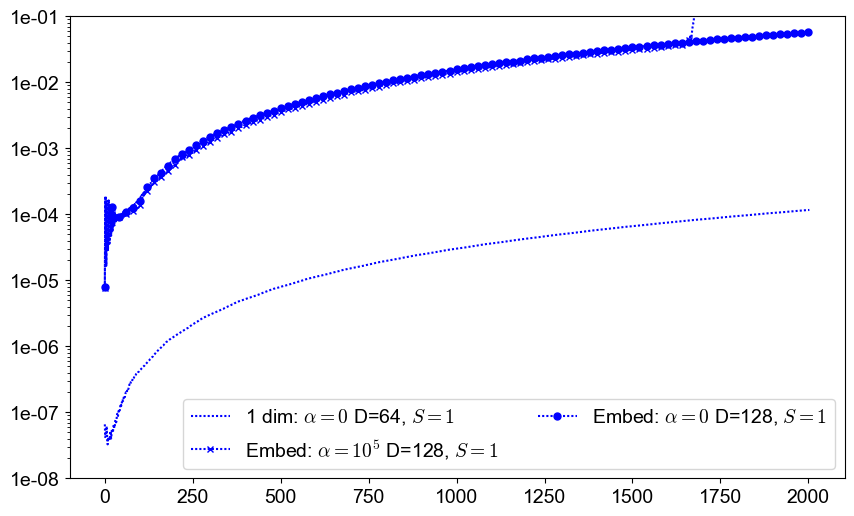

In [23]:
plt.figure(figsize=(10,6))

alpha1, alpha2, alpha3, alpha4 = 0.,0.0,64,1.
plt.plot(MSE_Error_at_time_1dim(alpha1, alpha2, alpha3, alpha4, 'best', 'no_embed_receivers'), linestyle = '-', color = 'b', dashes = (1, 1),  markevery = 20, ms = 5, label = '1 dim: ' r'$\alpha=0$' +' D=' + str(alpha3) + r', $S = 1$')

alpha1, alpha2, alpha3, alpha4 = 1e5, 0.0, 128, 0
plt.plot(MSE_Error_at_time(alpha1, alpha2, alpha3, alpha4), linestyle = '-', color = 'b', marker = 'x', dashes = (1, 1),  markevery = 20, ms = 5, label = 'Embed: 'r'$\alpha=10^5$' +' D=' + str(alpha3) + r', $S = 1$')

alpha1, alpha2, alpha3, alpha4 = 0., 0.0, 128, 0
plt.plot(MSE_Error_at_time(alpha1, alpha2, alpha3, alpha4), linestyle = '-', color = 'b', marker = 'o', dashes = (1, 1),  markevery = 20, ms = 5, label = 'Embed: 'r'$\alpha=0$' + ' D=' + str(alpha3) + r', $S = 1$')

# plt.xticks([0, 41, 200, 400])
plt.ylim([1e-8, 1e-1])
plt.yscale('log')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0e}'.format(x) for x in current_values])
plt.legend(loc = 'lower right', ncol = 2)
# plt.savefig('../../../../Overleaf_repos/Graph_Network_DG/Figs/Wave_eq/Error_compare_embed_and_no_embed.pdf', bbox_inches='tight')
# plt.close()

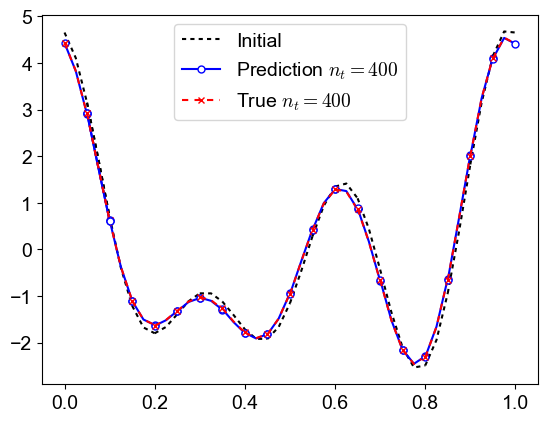

In [35]:
def plot_figures(alpha1, alpha2, alpha3, alpha4, Nt, sample):
    Pred_sols, True_data = load_from_file_1dim(alpha1, alpha2, alpha3, alpha4,'best', 'no_embed_receivers')
    x = np.loadtxt('../MATLAB/x.txt', delimiter = ',')

    for i in range(K):
        plt.plot(x[:,i], np.reshape(True_data[sample, 0,:], (K, N + 1))[i,:], linestyle = '-', color = 'k', dashes = (2, 2))
        plt.plot(x[:,i], np.reshape(Pred_sols[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'b', marker = 'o',  markevery = N, ms = 5, mfc = 'w')
        plt.plot(x[:,i], np.reshape(True_data[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'r', marker = 'x', dashes = (3, 3),  markevery = 3, ms = 5)
    
    i = 1
    plt.plot(x[:,i], np.reshape(True_data[sample, 0,:], (K, N + 1))[i,:], linestyle = '-', color = 'k', dashes = (2, 2), label = 'Initial')
    plt.plot(x[:,i], np.reshape(Pred_sols[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'b', marker = 'o',  markevery = N, ms = 5, mfc = 'w', label = 'Prediction ' + r'$n_t = 400$')
    plt.plot(x[:,i], np.reshape(True_data[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'r', marker = 'x', dashes = (3, 3),  markevery = 3, ms = 5, label = 'True ' + r'$n_t = 400$')
    
    plt.legend(loc = 'best')
    
    filename = 'Samples_no_embed_Dim_D_' + str(alpha1) + '_batchsize_' + str(alpha2) + '_sequence_' + str(alpha3)
    plt.show()
    # plt.savefig('../../../../Overleaf_repos/Graph_Network_DG/Figs/Wave_eq/' + filename + '.pdf', bbox_inches='tight')
    # plt.close()


Nt = 1000
sample = 9
plot_figures(0.,0.0,64,1., Nt, sample)
# plot_figures(1e5, 0.0, 128, 10, Nt, sample)
# plot_figures(1e5, 0.0, 128, Nt, sample)
# plot_figures(0., 0.0, 256, Nt, sample)
# plot_figures(1e5, 0.0, 256, Nt, sample)




In [ ]:
pred_sols

In [ ]:
Nt = 400
sample = 9

x = np.loadtxt('../MATLAB/x.txt', delimiter = ',')

for i in range(K):
    plt.plot(x[:,i], np.reshape(Test_data[sample, 0,:], (K, N + 1))[i,:], linestyle = '-', color = 'k', dashes = (2, 2))
    plt.plot(x[:,i], np.reshape(pred_sols[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'b', marker = 'o',  markevery = N, ms = 5, mfc = 'w')
    plt.plot(x[:,i], np.reshape(Test_data[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'r', marker = 'x', dashes = (3, 3),  markevery = 3, ms = 5)

i = 1
plt.plot(x[:,i], np.reshape(Test_data[sample, 0,:], (K, N + 1))[i,:], linestyle = '-', color = 'k', dashes = (2, 2), label = 'Initial')
plt.plot(x[:,i], np.reshape(pred_sols[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'b', marker = 'o',  markevery = N, ms = 5, mfc = 'w', label = 'Prediction ' + r'$n_t = 400$')
plt.plot(x[:,i], np.reshape(Test_data[sample, Nt,:], (K, N + 1))[i,:], linestyle = '-', color = 'r', marker = 'x', dashes = (3, 3),  markevery = 3, ms = 5, label = 'True ' + r'$n_t = 400$')

plt.legend(loc = 'best')

filename = 'Samples_no_embed_Dim_D_' + str(alpha1) + '_batchsize_' + str(alpha2) + '_sequence_' + str(alpha3)
plt.show()